---

<h2 style="text-align: center;"><b>Нейрон с сигмоидой</b></h2>

---

In [6]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

Напомним, что сигмоидальная функция (сигмоида) выглядит так:  
    
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

<img src="https://cdn-images-1.medium.com/max/1200/1*IDAnCFoeXqWL7F4u9MJMtA.png" width=500px height=350px>

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0), но здесь уже будет другая функция активации:

$$MSE\_Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{n}\sum_{i=1}^{n} (\sigma(w \cdot X_i) - y_i)^2$$ 

Здесь $w \cdot X_i$ - скалярное произведение, а $\sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида.  

**Примечание:** В формуле предполагается, что $b$ - свободный член - является частью вектора весов: $w_0$. Тогда, если к $X$ приписать слева единичный столбец, в скалярном произведении $b$ будет именно как свободный член. При реализации класса $b$ нужно считать отдельно (чтобы было нагляднее).

Можем взять производную лосса по весам и спускаться в пространстве весов в направлении наискорейшего убывания функции лосса. Формула для обновления весов в градиентном спуске такая:

$$w^{k+1} = w^{k} - \alpha \frac{\partial Loss}{\partial w} (w^{k})$$

$w^k$ -- вектор весов на $k$-ой итерации

Распишем дальше:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
\frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)(\sigma(w \cdot x_i))_{w_j}' = \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$

* Градиент $Loss$'а по вектору весов -- это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i1} \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i2} \\
           \vdots \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Реализуем сигмоиду и её производную:

In [1]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

In [2]:
def sigmoid_derivative(x):
    """Производная сигмоиды"""
    return sigmoid(x) * (1 - sigmoid(x))

Теперь нужно написать нейрон с сигмоидной функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [3]:
def loss(y_pred, y):
    '''
    Считаем среднеквадратичную ошибку
    '''
    y_pred = y_pred.reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    return 0.5 * np.mean((y_pred - y) ** 2)

In [4]:
class Neuron:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b

        
    def activate(self, x):
        return sigmoid(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрон при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрон 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.1):
        """
        Обновляет значения весов нейрон в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w = self.w - learning_rate * (X.T @ ((sigma - y) * sigma * (1 - sigma))) / n
        self.b = self.b - learning_rate * np.mean((sigma - y) * sigma * (1 - sigma))
    
    
    def fit(self, X, y, num_epochs=5000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: loss_values -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            loss_values.append(loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)
        
        return loss_values

**Тестирование нейрона**

Протестировуем новый нейрон **на тех же данных** по аналогии с тем, как это было проделано с перцептроном.  

**Проверка forward_pass()**

In [7]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 3.],
              [2., 4.],
              [-1., -3.2]])

neuron = Neuron(w, b)
y_pred = neuron.forward_pass(X)
print ("y_pred = " + str(y_pred))

y_pred = [[0.99987661]
 [0.99999386]
 [0.00449627]]


**Проверка backward_pass()**

In [8]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [9]:
neuron.backward_pass(X, y, y_pred)

print ("w = " + str(neuron.w))
print ("b = " + str(neuron.b))

w = [[0.99985106]
 [1.99952388]]
b = 2.000148326741343


Посмотрим, как меняется функция потерь в течение процесса обучения на реальных данных - датасет "Яблоки и Груши":

In [11]:
data = pd.read_csv("F:/Courses/Jupyter/dataframe/apples_pears.csv")

In [12]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


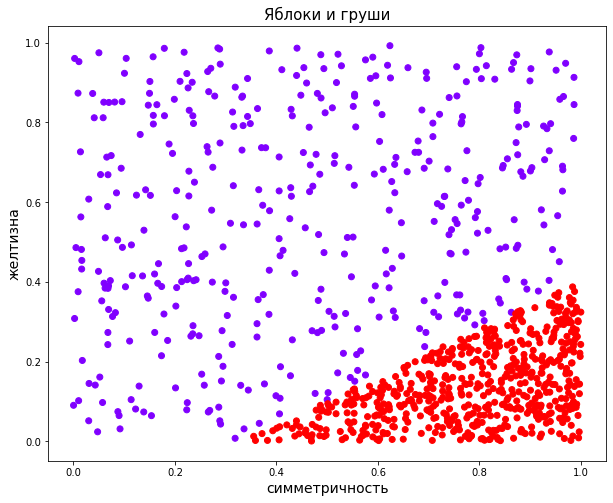

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Обозначим, что здесь признаки, а что - классы:

In [14]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

**Вывод функции потерь**  
Функция потерь должна убывать и в итоге стать близкой к 0

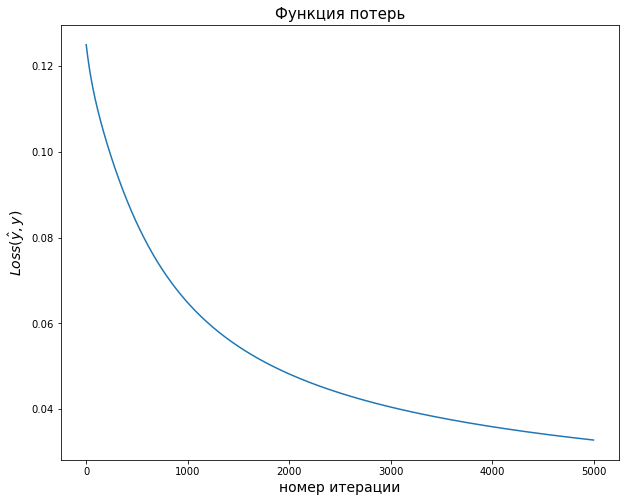

CPU times: total: 1.33 s
Wall time: 1.39 s


In [15]:
%%time

neuron = Neuron()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как нейрон классифицировал объекты из выборки:

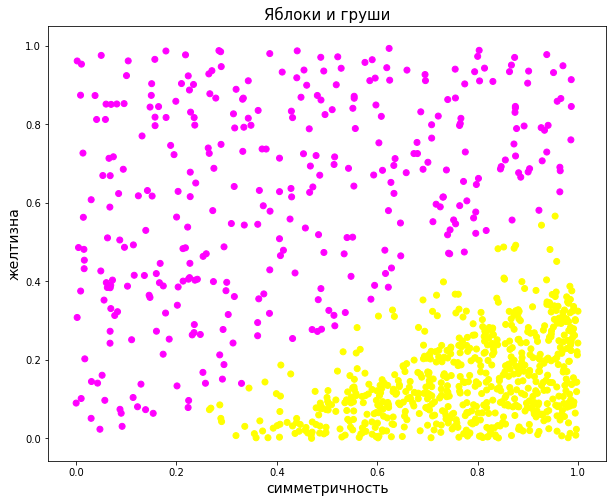

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

На самом деле то, что вы здесь наблюдаете (плохое качество разделения) -- последствие **затухающих градиентов (vanishing gradients)**. Мы позже ещё поговорим об этом (то есть о том, почему это происходит в данном случае).

Попробуем увеличить количество итераций градиентного спуска (50k итераций):

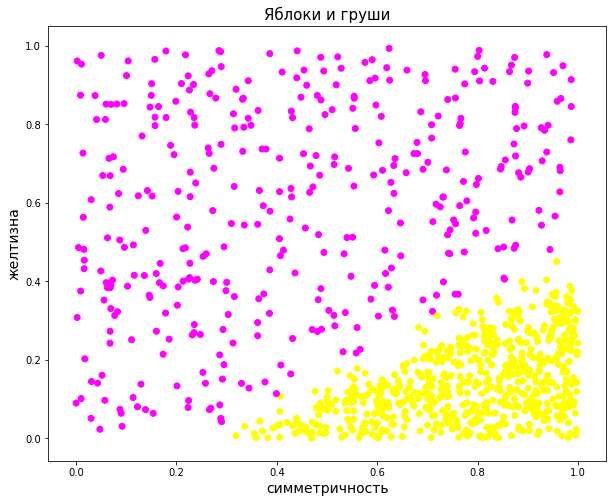

Wall time: 5.03 s


In [0]:
%%time

neuron = Neuron()
loss_values = neuron.fit(X, y, num_epochs=50000)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Что ж, стало лучше. Градиенты "текут" медленно, но верно.

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

0). Статья от Стэнфорда: http://cs231n.github.io/neural-networks-1/

1). Хорошая статья про функции активации: https://www.jeremyjordan.me/neural-networks-activation-functions/

2). [Видео от Siraj Raval](https://www.youtube.com/watch?v=-7scQpJT7uo)

3). Современная статья про функции активации. Теперь на хайпе активация **$swish(x) = x\sigma (\beta x)$:** https://arxiv.org/pdf/1710.05941.pdf (кстати, при её поиске в некоторой степени использовался neural architecture search)

4). **SeLU** имеет очень интересные, доказанные с помощью теории вероятностей свойства: https://arxiv.org/pdf/1706.02515.pdf (да, в этой статье 102 страницы)